Imports

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from keras.datasets import mnist
from keras.utils import to_categorical


ACTIVATION FUNCTIONS

In [17]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)


In [18]:

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.1, bias_init="zeros"):
        self.lr = learning_rate

        # Weights
        self.W1 = np.random.randn(input_size, hidden_size)
        self.W2 = np.random.randn(hidden_size, output_size)

        # Bias Initialization
        if bias_init == "zeros":
            self.b1 = np.zeros((1, hidden_size))
            self.b2 = np.zeros((1, output_size))
        elif bias_init == "random":
            self.b1 = np.random.randn(1, hidden_size)
            self.b2 = np.random.randn(1, output_size)

    def forward(self, X):
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = sigmoid(self.Z1)
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = sigmoid(self.Z2)
        return self.A2

    def backward(self, X, y, output):
        m = X.shape[0]
        dZ2 = (output - y) * sigmoid_derivative(output)
        dW2 = np.dot(self.A1.T, dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        dZ1 = np.dot(dZ2, self.W2.T) * sigmoid_derivative(self.A1)
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1


LOADING AND PREPARING DATA

In [19]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 784) / 255.0
X_test = X_test.reshape(-1, 784) / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Subset for fast training
X_train, y_train = X_train[:1000], y_train[:1000]


INITIALIZING AND TRAINING TO THE MODEL

In [20]:
model = NeuralNetwork(784, 64, 10, learning_rate=0.1, bias_init="random")

losses, accuracies = [], []
for epoch in range(1000):
    out = model.forward(X_train)
    model.backward(X_train, y_train, out)
    
    loss = ((y_train - out) ** 2).mean()
    acc = (out.argmax(axis=1) == y_train.argmax(axis=1)).mean()

    losses.append(loss)
    accuracies.append(acc)
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {acc*100:.2f}%")


Epoch 0: Loss = 0.4916, Accuracy = 15.60%
Epoch 100: Loss = 0.1887, Accuracy = 10.20%
Epoch 200: Loss = 0.1138, Accuracy = 17.80%
Epoch 300: Loss = 0.0967, Accuracy = 21.00%
Epoch 400: Loss = 0.0942, Accuracy = 22.90%
Epoch 500: Loss = 0.0925, Accuracy = 24.90%
Epoch 600: Loss = 0.0909, Accuracy = 25.90%
Epoch 700: Loss = 0.0893, Accuracy = 26.80%
Epoch 800: Loss = 0.0879, Accuracy = 27.90%
Epoch 900: Loss = 0.0865, Accuracy = 28.50%


PLOT LOSS AND ACCURACY

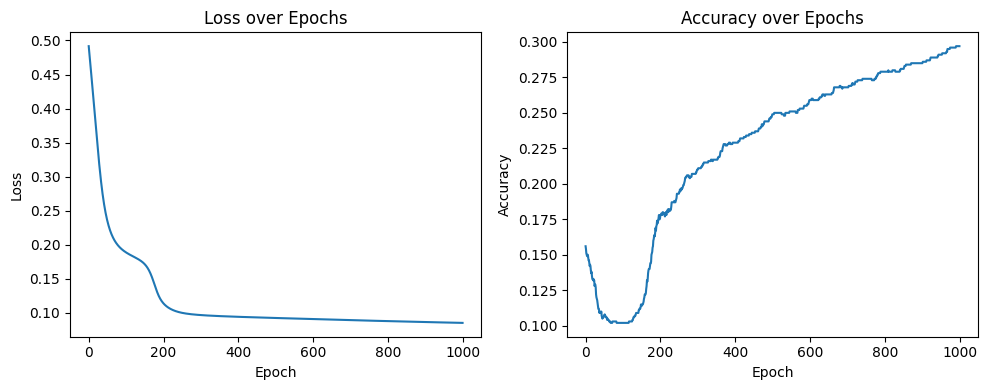

In [21]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


PREDICTIONS

In [22]:
def init_db():
    conn = sqlite3.connect("database.db")
    c = conn.cursor()
    c.execute("""CREATE TABLE IF NOT EXISTS predictions (
                 id INTEGER PRIMARY KEY,
                 input TEXT,
                 predicted INTEGER
             )""")
    conn.commit()
    conn.close()

def save_prediction(X, preds):
    conn = sqlite3.connect("database.db")
    c = conn.cursor()
    for x, p in zip(X, preds):
        c.execute("INSERT INTO predictions (input, predicted) VALUES (?, ?)",
                  (str(x.tolist()), int(np.argmax(p))))
    conn.commit()
    conn.close()

# Run it
init_db()
sample_X = X_train[:10]
sample_pred = model.forward(sample_X)
save_prediction(sample_X, sample_pred)
